# Configure the Library

In [133]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import dataloader, dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.simplefilter('ignore')

# load dataset

In [134]:
train = pd.read_csv('./dataset/train.csv.zip')
test = pd.read_csv('./dataset/test.csv.zip')
test_label = pd.read_csv('./dataset/test_labels.csv.zip')
#train.head()
#test.head()
#test_label.head()

In [135]:
new_test = pd.merge(test, test_label, on='id', how='inner')
new_test = new_test[(new_test.iloc[:, 3:8] != -1).all(axis=1)]
#new_test = new_test.head(1000)

# Clean the dataset -- helper function for removing non-sense fragment

In [136]:
def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    #pattern = [zero or more character]

    text = re.sub('https?://\S+|www\.\S+', '', text)
    #pattern = removes (http),://, 'and' www.
    
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #pattern = any punctionation

    text = re.sub('\n', '', text)
    #pattern = any new line

    text = re.sub('\w*\d\w*', '', text)
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]

    return text


train['clean'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
new_test['clean'] = new_test['comment_text'].apply(str).apply(lambda x: clean_text(x))

# DataLoader

In [137]:
class BertDataSet(dataset.Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_len, if_train=True):
        self.texts = texts
        #self.labels = labels.to_numpy()
        self.if_train = if_train
        if self.if_train:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts.iloc[item])
        
        if self.if_train:
            label = self.labels.iloc[item]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )

        if self.if_train:
            return {
                #'text': text,
                'input_ids':torch.tensor(inputs['input_ids'], dtype=torch.long),
                'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.float)
            }
        else:
            return{
            'input_ids':torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long)
            }
     

# Model definition

In [138]:
train_batch = 32
valid_batch = 32

epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f"The devices using is : {device}")

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6).to(device)

#Using K-folder
kfold = 5
train['kfold'] = train.index % kfold
train.index % kfold

p_train = train[train["kfold"] != 0].reset_index(drop = True)
p_valid = train[train["kfold"] == 0].reset_index(drop = True)

#p_train.head()

len(p_train)

#Setting dataset
train_dataset = BertDataSet(p_train['clean'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 128)
valid_dataset = BertDataSet(p_valid['clean'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 128)

train_dataloader = dataloader.DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 0, shuffle = True)
valid_dataloader = dataloader.DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 0, shuffle = False)


fold_losses = []
fold_valid = []

best_model  = None
best_loss = None
best_index = 0

loss_fn = nn.BCEWithLogitsLoss() # for sigmoid on multi-label tasks
loss_fn.to(device)

LR  = 2e-7

optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2)

scaler = torch.cuda.amp.GradScaler()

train_steps = int((len(train) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)



The devices using is : cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# train

## old_version

In [ ]:
'''
kf = KFold(n_splits = 5, shuffle = True, random_state=42)

train_index, valid_index = next(next(iter(kf.split(train))))

train_kf = train.iloc[train_index]
valid_kf = train.iloc[valid_index]

train_dataset = BertDataSet(train_kf['clean'], train_kf[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 128)
valid_dataset = BertDataSet(valid_kf['clean'], valid_kf[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 128)

#train_dataset = BertDataSet(train_kf, tokenizer, eval_mode = False)
#valid_dataset = BertDataSet(valid_kf, tokenizer, eval_mode = True)

train_dataloader = dataloader.DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 0, shuffle = True)
valid_dataloader = dataloader.DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 0, shuffle = False)

training_losses = []
valid_losses = []

total_steps = len(train_dataloader) * epochs

#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


for epoch in range(epochs):   
    model.train()
    train_losses = []
    valid_losses = []
    with torch.cuda.amp.autocast():
    
        for batch in tqdm(train_dataloader):
            
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels = labels)
            outputs = outputs['logits']
            
            toxic_labels = batch['labels'].to(device, non_blocking=True)
            loss = loss_fn(outputs, toxic_labels)
            
            #loss = outputs.loss
            train_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            #scheduler.step()
            
        avg_loss = np.mean(train_losses)
        training_losses.append(avg_loss)
        print(f"Training Epoch {epoch+1}/{epochs}, Loss: {avg_loss}.")
    
        model.eval()
        true_labels = []
        predictions = []
        
        for batch in valid_dataloader:
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['labels'].to(device)
                    
            
            with torch.no_grad():
                #outputs = model(input_ids, attention_mask = attention_mask)
                outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
                
            outputs = outputs['logits'].squeeze(-1)
            
            toxic_labels = batch['labels'].to(device, non_blocking=True)
            loss = loss_fn(outputs, toxic_labels)
            #loss = outputs.loss
            valid_losses.append(loss.item())
            
        avg_valid_loss = np.mean(valid_losses)
        valid_losses.append(avg_valid_loss)   
        #f1 = f1_score(true_labels, predictions, average='weighted')  #Error : Classification metrics can't handle a mix of multilabel-indicator and binary targets       
        print(f"Validating Epoch {epoch+1}/{epochs}, Loss: {avg_valid_loss}")
    
best_model = model
best_loss = avg_valid_loss
fold_losses = training_losses
fold_valid = valid_losses
best_model.save_pretrained('./fintune_bert')    
'''

In [ ]:
'''
# draw the losses of the best model
best_train_losses = fold_losses
best_valid_losses = valid_losses

plt.plot(best_train_losses, color='green')
plt.plot(best_valid_losses, color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Plot')
plt.show()
'''

## new_version

In [ ]:

def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in tqdm(train_dataloader):
        losses = []
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            
            ids = a['input_ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) 
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['labels'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
        
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() 
        scaler.step(optimizer) 
        scaler.update() 
                        
        scheduler.step() 
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in tqdm(valid_dataloader):
        losses = []
        ids = a['input_ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        
        with torch.no_grad():
            output = model(ids, mask)
            
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['labels'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

In [ ]:

train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for eboch in range(epochs):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
model.save_pretrained('./fintune_bert')

    

100%|██████████| 998/998 [01:54<00:00,  8.69it/s]


train losses: 0.1848 train accuracy: 0.805
valid losses: 0.1717 valid accuracy: 0.964


100%|██████████| 998/998 [01:55<00:00,  8.64it/s]


train losses: 0.0828 train accuracy: 0.968
valid losses: 0.0853 valid accuracy: 0.975


100%|██████████| 998/998 [01:54<00:00,  8.72it/s]


train losses: 0.0496 train accuracy: 0.976
valid losses: 0.0553 valid accuracy: 0.980


100%|██████████| 998/998 [01:57<00:00,  8.48it/s]


train losses: 0.0858 train accuracy: 0.979
valid losses: 0.0449 valid accuracy: 0.981


100%|██████████| 998/998 [01:57<00:00,  8.48it/s]


train losses: 0.0641 train accuracy: 0.980
valid losses: 0.0403 valid accuracy: 0.981


"\nstate = {\n            'state_dict': model.state_dict(),\n            'optimizer_dict': optimizer.state_dict()\n        }\n    \ntorch.save(state, './best_model.pth')\n"

Text(0.5, 0.98, 'Fold = 0')

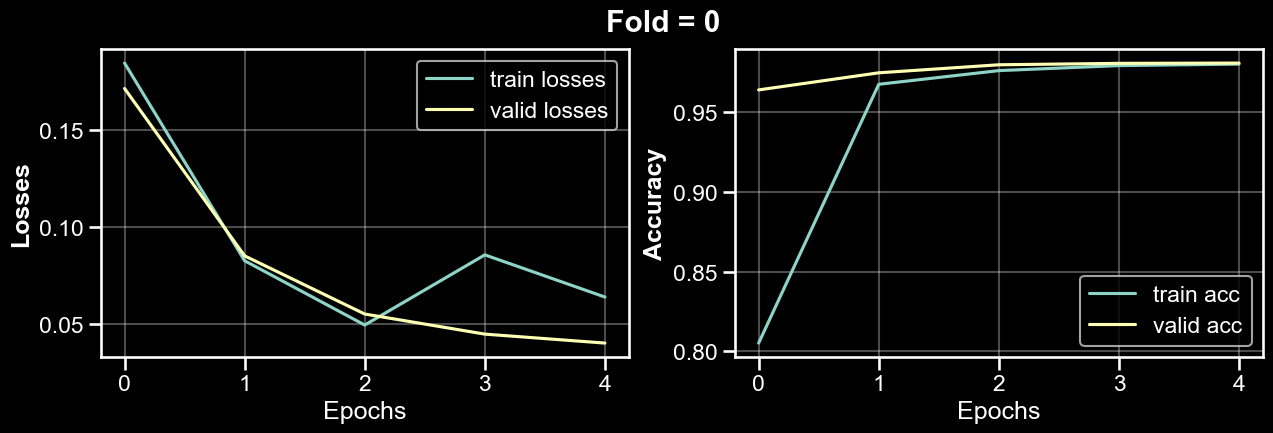

In [ ]:

x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 


100%|██████████| 998/998 [01:55<00:00,  8.67it/s]


Valid AUC_score : 0.9785761622330147


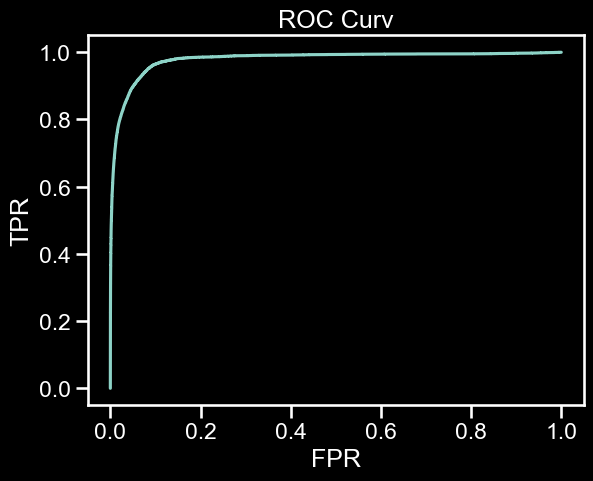

In [ ]:

config_path = './fintune_bert/config.json'
model_path = './fintune_bert/model.safetensors'
config = transformers.BertConfig.from_json_file(config_path)
model = transformers.BertForSequenceClassification.from_pretrained(model_path, config=config).to(device) 
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
valid_probs = np.asarray(valid_probs).flatten()
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

print("Valid AUC_score : " + str(roc_auc_score(y_valid, valid_probs)))

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()


# Evaluation

In [ ]:
#import gc
#tokenizer = None
#best_model = None
#model = None
#torch.cuda.empty_cache()
#gc.collect()

In [ ]:
def get_roc_auc(test_label, y_prob):
    # input: test_labels dim: (num_samples, num_labels), y_prob dim: (num_samples, num_labels)
    y_label_np = test_label.numpy() if hasattr(test_label, 'numpy') else test_label.cpu().numpy()
    y_test_np = y_prob.numpy() if hasattr(y_prob, 'numpy') else y_prob.cpu().numpy()

    n_classes = y_label_np.shape[1]  # Number of classes/labels

# Initialize lists to store fpr and tpr for each label
    all_fpr = []
    all_tpr = []
    label_names = []
    auc_scores = []
    # Compute ROC curve for each label
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_label_np[:, i], y_test_np[:, i])
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        auc = roc_auc_score(y_label_np[:, i], y_test_np[:, i])
        label_names.append(f"Label {i}")
        auc_scores.append(auc)

    # Plot ROC curve for each label
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(all_fpr[i], all_tpr[i], label=f'ROC curve (Label {i})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each label')
    plt.legend(loc='lower right')
    plt.show()
    auc_table = pd.DataFrame({'Label': label_names, 'AUC Score': auc_scores})

    print(auc_table)
     

In [ ]:
def get_accuracy(y_label, y_test):
    prediction = torch.where(y_test > 0.5, 1, 0)
    y_label_np = prediction.numpy() if hasattr(prediction, 'numpy') else prediction.cpu().numpy()
    y_test_np = y_label.numpy() if hasattr(y_label, 'numpy') else y_label.cpu().numpy()
    
    n_class = y_label_np.shape[1]
    n_samples = y_label_np.shape[0]

    total_num = y_label_np.shape[0] * y_label_np.shape[1]
    correct = 0
    for i in range(n_class):
        for j in range(n_samples):
            if y_test_np[j,i] == y_label_np[j,i]:
                correct += 1 
    accuracy = correct / total_num
    return accuracy


In [ ]:
def get_new_accuracy(y_label, y_test):
    prediction = torch.where(y_test > 0.5, 1, 0)
    y_label_np = prediction.numpy() if hasattr(prediction, 'numpy') else prediction.cpu().numpy()
    y_test_np = y_label.numpy() if hasattr(y_label, 'numpy') else y_label.cpu().numpy()
    
    n_class = y_label_np.shape[1]
    n_samples = y_label_np.shape[0]

    total_num = y_label_np.shape[0] * y_label_np.shape[1]
    false = 0
    for i in range(n_samples):
        for j in range(n_class):
            if y_test_np[i,j] != y_label_np[i,j]:
                false += 1
                continue 
    accuracy = 1- false / n_samples
    return accuracy

In [ ]:
def get_F1(y_label, y_test):
    prediction = torch.where(y_test > 0.5, 1, 0)
    y_label_np = prediction.numpy() if hasattr(prediction, 'numpy') else prediction.cpu().numpy()
    y_test_np = y_label.numpy() if hasattr(y_label, 'numpy') else y_label.cpu().numpy()
    
    n_class = y_label_np.shape[1]
    n_samples = y_label_np.shape[0]

    f1_scores = []
    for i in range(n_class):
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        for j in range(n_samples):
            if y_test_np[j,i] == 1 and y_label_np[j,i] == 1:
                true_positives += 1
            elif y_test_np[j,i] == 1 and y_label_np[j,i] == 0:
                false_positives += 1
            elif y_test_np[j,i] == 0 and y_label_np[j,i] == 1:
                false_negatives += 1

        precision = true_positives / max(1, true_positives + false_positives)
        recall = true_positives / max(1, true_positives + false_negatives)
        
        f1 = 2 * (precision * recall) / max(1e-6, precision + recall)
        f1_scores.append(f1)

    return f1_scores

In [ ]:
#loading test_dataset
test_dataset = BertDataSet(new_test['clean'], None, tokenizer, 128, if_train = False)
test_dataloader = dataloader.DataLoader(test_dataset, batch_size = 64, pin_memory = True, num_workers = 0, shuffle = True)

config_path = './fintune_bert/config.json'
model_path = './fintune_bert/model.safetensors'
#new_model_path = './best_model.pth'

config = transformers.BertConfig.from_json_file(config_path)
best_model = transformers.BertForSequenceClassification.from_pretrained(model_path, config=config).to(device)

#best_model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6).to(device)

probability_tensors = None

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(len(test_dataset))

63978


In [ ]:
best_model.eval()
with torch.no_grad():
    for test in tqdm(test_dataloader):
        
        ids = test['input_ids'].to(device)
        mask = test['mask'].to(device)
        outputs = best_model(ids, mask)
        #print(outputs.keys())
        results = outputs['logits']
        #print(results)
        
        raw_predictions = torch.sigmoid(results)    
        prediction = torch.where(raw_predictions > 0.5, 1, 0)
        
        #print(raw_predictions)
        #print(prediction)
        
        if probability_tensors == None:
            probability_tensors = raw_predictions
        else:
            probability_tensors = torch.cat((probability_tensors, raw_predictions), dim=0)
            
        #break
        
    probability_tensors = probability_tensors.detach().to('cpu')   
    print(probability_tensors)

100%|██████████| 1000/1000 [02:31<00:00,  6.59it/s]


tensor([[0.4948, 0.6238, 0.3914, 0.4738, 0.4599, 0.3545],
        [0.5341, 0.6324, 0.3631, 0.4159, 0.3452, 0.3873],
        [0.4973, 0.6633, 0.3811, 0.3996, 0.2783, 0.4114],
        ...,
        [0.4943, 0.6651, 0.3706, 0.4181, 0.3358, 0.3831],
        [0.5017, 0.6413, 0.3646, 0.4284, 0.3509, 0.3967],
        [0.5155, 0.6374, 0.4189, 0.4532, 0.4379, 0.3868]])


#

In [ ]:
'''
ground_truth = torch.tensor(new_test[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].values)
y_rand = torch.rand(200,6)
# print(y_test)
# print(y_label)
get_roc_auc(ground_truth, probability_tensors)
#get_roc_auc(y_label, y_rand)
'''

"\nground_truth = torch.tensor(new_test[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].values)\ny_rand = torch.rand(200,6)\n# print(y_test)\n# print(y_label)\nget_roc_auc(ground_truth, probability_tensors)\n#get_roc_auc(y_label, y_rand)\n"

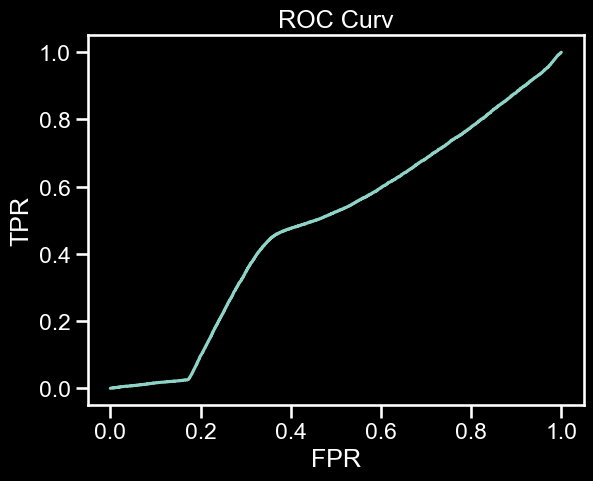

AUC score : 0.4883875779989546
Accuracy : 0.6821277105671741


In [ ]:
probability = np.asarray(probability_tensors).flatten()
ground_truth = new_test[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
fpr, tpr, _ = roc_curve(ground_truth, probability)

post_probability = np.where(probability > 0.5, 1, 0)
accuracy = np.sum(ground_truth == post_probability)/probability.shape[0]


fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

print("AUC score : " + str(roc_auc_score(ground_truth, probability)))
print("Accuracy : " + str(accuracy))

In [ ]:
ground_truth = torch.tensor(new_test[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].values)
get_accuracy(ground_truth, probability_tensors)

0.9288739879333521

In [ ]:
get_new_accuracy(ground_truth, probability_tensors)

0.5732439276001126

In [ ]:
get_F1(ground_truth,probability_tensors)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]